Autores: Bruno Leal Fonseca & Guilherme Namen Pimenta

Repositório Github: https://github.com/Nagi0/bh-traffic-data-mining

# Business Understanding

Os avanços nas tecnologias para Cidades Inteligentes estão propiciando um controle maior das atividades do cotidiano. Os pilares tecnológicos de Internet Das Coisas, Portais de Dados Abertos e os Algoritmos de Aprendizado de Máquina estão provendo meios de aperfeiçoamento das políticas públicas. Especificamente para este projeto, o foco se restringe aos dados de fluxo de veículos da capitados por radares (IOT) da Capital Mineira providos pelo Portal de Dados Abertos da Prefeitura de Belo Horizonte (Dados Abertos) a serem processados pelos algoritmos estudados na aula de mineração de dados (Algoritmos de Aprendizado de Máquina). A relevância dos resultados é importante para caracterizar o trânsito para prover bases para novas políticas públicas 
voltadas para o bem-estar do munícipe.

O objetivo é encontrar determinados padrões de comportamento frequentes dos motoristas em uma determinada via de Belo Horizonte. A base é composta por uma grande quantidade de amostras, por se tratar de todos os dados de radares da cidade de Belo Horizonte. O volume de veículos e vias possíveis que podem ser analisadas é gigantesco, portanto, foi decidido focar em uma via específica,onde será possível encontrar padrões locais mais específicos, possibilitando trabalhar com um volume menor de dados e reduzindo o custo computacional para conduzir as análises e execução dos algoritmos. Almeja-se responder algumas perguntas que podem ajudar a descrever melhor o perfil dos motoristas que circulam na via. Como é a distribuição da velocidade em determinadas faixas de horário? Quais veículos geralmente estão acima da velocidade permitida? Em quais horários o trânsito aparenta estar mais rápido ou devagar? Em quais lugares é mais comum se encontrar maiores infrações de trânsito etc. Isso irá permitir descobrir qual o perfil dos motoristas em determinados locais e horários, afinal é comum que determinado grupo de pessoas use a via em diferentes horários e ou apenas certos trechos dela. 

# Mineração de Itemsets e Sequências

## Data Understanding & Data Preparation

Para processar a base de registros de veículos da cidade de Belo Horizonte foi escolhido o mês de fevereiro de 2022. A base é muito grande, por isso filtramos para processar apenas o mês de fevereiro os veículos registrados na Av. do Contorno. Para tal o comando Powershell foi executado para gerar a base filtrada:  
```
Get-ChildItem "." -Filter *.json -Recurse | select -ExpandProperty FullName | %{Get-Content $_ | Out-String | ConvertFrom-Json | Where-Object {$_.ENDEREÇO -like 'Av. do Contorno*'}} | Export-Csv
```
A bse resultante possui 4.903.487 registros.

In [ ]:
Sys.setlocale(locale = 'en_US.UTF-8')
sessionInfo()

Warning message in Sys.setlocale(locale = "en_US.UTF-8"):
"using locale code page other than 1252 may cause problems"


[1] "LC_COLLATE=en_US.UTF-8;LC_CTYPE=en_US.UTF-8;LC_MONETARY=en_US.UTF-8;LC_NUMERIC=C;LC_TIME=en_US.UTF-8"

R version 4.4.2 (2024-10-31 ucrt)
Platform: x86_64-w64-mingw32/x64
Running under: Windows Server 2019 x64 (build 17763)

Matrix products: default


locale:
[1] LC_COLLATE=en_US.UTF-8  LC_CTYPE=en_US.UTF-8    LC_MONETARY=en_US.UTF-8
[4] LC_NUMERIC=C            LC_TIME=en_US.UTF-8    
system code page: 1252

time zone: America/Sao_Paulo
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
 [1] digest_0.6.37     IRdisplay_1.1     utf8_1.2.4        base64enc_0.1-3  
 [5] fastmap_1.2.0     glue_1.8.0        htmltools_0.5.8.1 repr_1.1.7       
 [9] lifecycle_1.0.4   cli_3.6.3         fansi_1.0.6       vctrs_0.6.5      
[13] pbdZMQ_0.3-13     compiler_4.4.2    tools_4.4.2       evaluate_1.0.1   
[17] pillar_1.9.0      crayon_1.5.3      rlang_1.1.4       jsonlite_1.8.9   
[21] IRkernel_1.3.2    uuid_1.2-1       

In [ ]:
library(tidyverse)
#Função para gerar o banco de dados
gera_banco_dados <- function() {
  
  #Carrega arquivo
  contorno <- read_csv('contorno.csv')
  #Filtra veículos com comprimento inválido e classificação indefinida
  contorno <- contorno %>% filter(`CLASSIFICAÇÃO` != 'INDEFINIDO')
  contorno <- contorno %>% filter(TAMANHO < 20)
  #Faz o parser da data
  contorno$`DATA HORA` <-
    parse_date_time(
      contorno$`DATA HORA`,
      '%d/%m/%Y %I:%M:%S %p',
      tz = "America/Sao_Paulo")
  #Realiza a transformação da velocidade em fatores
  velocidade <- c("0-40", "41-60", "61-100", ">100", "NA")
  cut_points <- c(0, 41, 61, Inf)
  i <- findInterval(contorno$`VELOCIDADE AFERIDA`, cut_points)
  v_fac <- velocidade[i]
  v_fac[is.na(contorno$`VELOCIDADE AFERIDA`)] <- velocidade[length(velocidade)]
  contorno$`VELOCIDADE AFERIDA` <- factor(v_fac, levels = velocidade)
  #Transforma valores em fatores
  contorno$CLASSIFICAÇÃO <- factor(contorno$CLASSIFICAÇÃO,ordered =FALSE)
  contorno$SENTIDO <- factor(contorno$SENTIDO,ordered =FALSE)
  contorno$FAIXA <- factor(contorno$FAIXA,ordered =FALSE)
  contorno$`ID DE ENDEREÇO` <- factor(contorno$`ID DE ENDEREÇO`,ordered =FALSE)
  
  #Transforma o comprimento do veículo em 3 faixas proporcional à classificação do veículo
  contorno <- 
    contorno %>%
    group_by(`CLASSIFICAÇÃO`) %>%
    mutate(BIN = cut(TAMANHO,3,c('PEQUENO','MÉDIO','GRANDE'))) %>%
    ungroup()
  return(contorno)
}

#Gera os registros do índices
indices <- function(dados) {
  A <- levels(dados$FAIXA)
  B <- levels(dados$`ID DE ENDEREÇO`)
  C <- levels(dados$`VELOCIDADE AFERIDA`)
  D <- levels(dados$`CLASSIFICAÇÃO`)
  E <- levels(dados$SENTIDO)
  F <- levels(dados$BIN)
  ind <-
    crossing(
      FAIXA=A,
      `ID DE ENDEREÇO`=B,
      #SENTIDO=E,
      `CLASSIFICAÇÃO`=D,
      BIN=F,
      `VELOCIDADE AFERIDA`=C
    )
  ind$ID <- 1:dim(ind)[1]
  return(ind)
}

#O preambulo é necessário para o processamento do arquivo pelo SPMF
gera_preambulo <- function(arquivo, tipos) {
  fileConn<-file(arquivo, encoding="UTF-8")
  writeLines(c("@CONVERTED_FROM_TEXT"), fileConn)
  close(fileConn)
  
  codigos <- tipos %>%
    unite("NOME", FAIXA:`VELOCIDADE AFERIDA`, remove = TRUE) %>%
    unite("CODIGO", ID, NOME, remove = TRUE, sep="=") %>%
    mutate(CODIGO=paste("@ITEM=", CODIGO, sep = ""))
  write.table(codigos,
              file = arquivo,
              sep = "",
              col.names = FALSE,
              row.names = FALSE,
              quote = FALSE,
              append=TRUE,
              fileEncoding="UTF-8")
  fileConn<-file(arquivo, "a")
  close(fileConn)
}

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


### Geração da Base

#### Filtros
Foram removidos os veículos classificados como INDEFINIDOS e os veículos de comprimento superior a 20 metros.

#### Agrupamentos
A velocidade aferida foi agrupada nos seguintes intervalos "0-40", "41-60", "61-100", ">100".
O comprimento dos veículos foram agrupados em 'PEQUENO','MÉDIO','GRANDE' de forma proporcial ao tipo de veículo

In [ ]:
contorno <- gera_banco_dados()

Rows: 4933535 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): DATA HORA, CLASSIFICAÇÃO, ENDEREÇO, SENTIDO
dbl (10): ID EQP, MILESEGUNDO, FAIXA, ID DE ENDEREÇO, VELOCIDADE DA VIA, VEL...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
contorno[1:3,]

ID EQP,DATA HORA,MILESEGUNDO,FAIXA,ID DE ENDEREÇO,VELOCIDADE DA VIA,VELOCIDADE AFERIDA,CLASSIFICAÇÃO,TAMANHO,NUMERO DE SÉRIE,LATITUDE,LONGITUDE,ENDEREÇO,SENTIDO,BIN
<dbl>,<dttm>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<fct>
193,2022-02-01 01:02:08,742,1,311,60,41-60,AUTOMÓVEL,4.1,3264,-19.9176,-43.94896,"Av. do Contorno, oposto ao nº 10812",Centro/Barro Preto,MÉDIO
193,2022-02-01 01:02:17,180,1,311,60,41-60,AUTOMÓVEL,3.9,3264,-19.9176,-43.94896,"Av. do Contorno, oposto ao nº 10812",Centro/Barro Preto,MÉDIO
193,2022-02-01 01:02:34,430,2,311,60,41-60,AUTOMÓVEL,4.7,3264,-19.9176,-43.94896,"Av. do Contorno, oposto ao nº 10812",Centro/Barro Preto,MÉDIO


### Geração do arquivo no formato SPMF
O aplicativo SPMF https://www.philippe-fournier-viger.com/spmf/ possui duas partes um preambulo contendo o identificador númerico e o nome do item e em seguida o conjunto de itensets somente contendo o identificador. Para gerar o identificador numérico, uma tabela de índice foi criada contendo todos os itens e seu respectivo código.
Em seguida os indentificadores são mesclados à base horiginal.

#### Item
O item constitui-se da faixa de trânsito seguida do id do endereço e do tipo, tamanho e velocidade do veículo.

In [ ]:
ind <- indices(contorno)
contorno <- contorno %>% inner_join(ind)

Joining with `by = join_by(FAIXA, `ID DE ENDEREÇO`, `VELOCIDADE AFERIDA`,
CLASSIFICAÇÃO, BIN)`


In [ ]:
ind[1:3,]

FAIXA,ID DE ENDEREÇO,CLASSIFICAÇÃO,BIN,VELOCIDADE AFERIDA,ID
<chr>,<chr>,<chr>,<chr>,<chr>,<int>
1,311,AUTOMÓVEL,GRANDE,>100,1
1,311,AUTOMÓVEL,GRANDE,0-40,2
1,311,AUTOMÓVEL,GRANDE,41-60,3


### Transação
A transação é o agrupamento dos itens durante o perído de 5 minutos. Por tanto queremos verificar os itens mais comuns em um intervalo de cinco minutos

In [ ]:
item_set <- contorno %>%
  group_by(day(`DATA HORA`), floor_date(`DATA HORA`, unit = "5minutes")) %>%
  summarise(
    ITEMSET = paste0(unique(ID), collapse = " "),
    .groups = 'drop') %>%
  select(ITEMSET)

In [ ]:
item_set[1:3,]

ITEMSET
<chr>
8 278 548 313 283 567 13 323 58 53 368 638 448 373 188 728 458 387 807 1037 367 493 1043 903 103 457 632 382 908 943 463 733 773 413 637 927
548 298 278 8 543 584 549 568 13 558 273 554 343 323 868 593 58 628 363 103 143 638 98 368 908 413 127 102 943 637 448 923 907 1042 458 412 373 132 134
277 548 313 278 549 294 569 553 8 543 274 283 593 328 603 323 58 908 1043 637 448 453 369 458 413 123 373 103 1042 808 1062 492 102 368 367 903 638 383 728


### Gerar o arquivo SPMF
Para gerar o arquivo escrevemos o preâmbulo e as transações.

In [ ]:
gera_preambulo("arquivo.txt", ind)
write(item_set$ITEMSET, "arquivo.txt", append = TRUE)

## Modeling

### Processamento da base
Para processar a base para e verificar quais itens mais frequêntes, o algoritmo NegFIM foi utilizado com suporte igqual a 90% 

In [ ]:
frequentes <- read.csv('frequentes.csv')
colnames(frequentes) <- c("Itemset", "Suporte")
frequentes

Itemset,Suporte
<chr>,<dbl>
4_328_AUTOMÓVEL_PEQUENO_41-60,7314
3_366_AUTOMÓVEL_MÉDIO_41-60,7345
3_366_AUTOMÓVEL_MÉDIO_41-60 4_349_AUTOMÓVEL_MÉDIO_41-60,7257
3_366_AUTOMÓVEL_MÉDIO_41-60 2_350_AUTOMÓVEL_MÉDIO_41-60,7283
2_349_AUTOMÓVEL_MÉDIO_0-40,7364
2_349_AUTOMÓVEL_MÉDIO_0-40 4_349_AUTOMÓVEL_MÉDIO_41-60,7262
2_349_AUTOMÓVEL_MÉDIO_0-40 2_350_AUTOMÓVEL_MÉDIO_41-60,7276
2_349_AUTOMÓVEL_PEQUENO_0-40,7385
2_349_AUTOMÓVEL_PEQUENO_0-40 4_349_AUTOMÓVEL_MÉDIO_41-60,7280


### Processamento de sequencias
Para processar dos dados em sequência agrupamos os registros em três sequências de 5 minutos, o número -1 divide as sequências.

In [ ]:
sequencia <- contorno %>%
  group_by(Dia = day(`DATA HORA`), Minuto = floor_date(`DATA HORA`, unit = "5minutes")) %>%
  summarise(
    ITEMSET = paste0(unique(ID), collapse = " "),
    .groups = 'drop') %>%
  group_by(Dia, floor_date(Minuto, unit = "15minutes")) %>%
  summarise(ITEMSET = paste0(ITEMSET, collapse = " -1 "), .groups = 'drop')

In [ ]:
sequencia$ITEMSET = paste(sequencia$ITEMSET, "-2")
gera_preambulo("arquivoseq.txt", ind)
write(sequencia$ITEMSET, "arquivoseq.txt", append = TRUE)

O algoritmo utilizado foi o SPADE Paralelizado com suporte mínimo de 0.95

In [ ]:
sq <- read.csv('seq.csv')
colnames(sq) <- c("Regra", "Suporte")
sq

Regra,Suporte
<chr>,<dbl>
1_328_AUTOMÓVEL_PEQUENO_41-60 -1,2607
1_349_AUTOMÓVEL_MÉDIO_41-60 -1,2595
1_349_AUTOMÓVEL_PEQUENO_0-40 -1,2624
1_349_AUTOMÓVEL_PEQUENO_41-60 -1,2667
2_328_AUTOMÓVEL_MÉDIO_41-60 -1,2623
2_328_AUTOMÓVEL_PEQUENO_41-60 -1,2612
2_349_AUTOMÓVEL_MÉDIO_0-40 -1,2655
2_349_AUTOMÓVEL_MÉDIO_41-60 -1,2677
2_349_AUTOMÓVEL_PEQUENO_0-40 -1,2650


### Processamento de regras sequências
Para processar as regras sequências foi utilizado o algoritmo TRulerGrowth com os seguintes parâmetros:
MinSup| Confiança Mínima | Tamanho da Janela
--|--|--|
0.9|0.9|3

In [ ]:
rsq <- read.csv('rule_seq.txt')
colnames(rsq) <- c("Regra", "Suporte", "Confiança")
#rsq[order(rsq$Confiança, decreasing = TRUE), ]
rsq

Regra,Suporte,Confiança
<chr>,<dbl>,<dbl>
4_370_AUTOMÓVEL_MÉDIO_0-40 ==> 1_349_AUTOMÓVEL_PEQUENO_41-60,2468,0.9341408
"4_370_AUTOMÓVEL_MÉDIO_0-40 ==> 1_349_AUTOMÓVEL_PEQUENO_41-60,4_349_AUTOMÓVEL_MÉDIO_41-60",2444,0.9250568
"4_370_AUTOMÓVEL_MÉDIO_0-40 ==> 1_349_AUTOMÓVEL_PEQUENO_41-60,2_349_AUTOMÓVEL_MÉDIO_41-60",2446,0.9258138
"4_370_AUTOMÓVEL_MÉDIO_0-40 ==> 1_349_AUTOMÓVEL_PEQUENO_41-60,2_349_AUTOMÓVEL_MÉDIO_41-60,4_349_AUTOMÓVEL_MÉDIO_41-60",2427,0.9186223
"4_370_AUTOMÓVEL_MÉDIO_0-40 ==> 1_349_AUTOMÓVEL_PEQUENO_41-60,2_349_AUTOMÓVEL_MÉDIO_41-60,2_349_AUTOMÓVEL_PEQUENO_41-60",2435,0.9216503
"4_370_AUTOMÓVEL_MÉDIO_0-40 ==> 1_349_AUTOMÓVEL_PEQUENO_41-60,2_349_AUTOMÓVEL_MÉDIO_41-60,2_349_AUTOMÓVEL_PEQUENO_41-60,4_349_AUTOMÓVEL_MÉDIO_41-60",2417,0.9148372
"4_370_AUTOMÓVEL_MÉDIO_0-40 ==> 1_349_AUTOMÓVEL_PEQUENO_41-60,2_349_AUTOMÓVEL_MÉDIO_41-60,2_350_AUTOMÓVEL_MÉDIO_41-60",2425,0.9178653
"4_370_AUTOMÓVEL_MÉDIO_0-40 ==> 1_349_AUTOMÓVEL_PEQUENO_41-60,2_349_AUTOMÓVEL_MÉDIO_41-60,3_349_AUTOMÓVEL_MÉDIO_41-60",2422,0.9167298
"4_370_AUTOMÓVEL_MÉDIO_0-40 ==> 1_349_AUTOMÓVEL_PEQUENO_41-60,2_349_AUTOMÓVEL_PEQUENO_41-60",2454,0.9288418


In [ ]:
contorno %>% distinct(`ID DE ENDEREÇO`,ENDEREÇO, SENTIDO)

ID DE ENDEREÇO,ENDEREÇO,SENTIDO
<chr>,<chr>,<fct>
311,"Av. do Contorno, oposto ao nº 10812",Centro/Barro Preto
328,"Av. do Contorno, nº 10.730",Barro Preto/Centro
349,"Av. do Contorno, nº 629",Praça da Estação / Rodoviária
350,"Av. do Contorno, nº 4.045",Savassi / Sta. Efigênia
366,"Av. do Contorno, oposto ao nº 5.445",São Lucas/Savassi
370,"Av. do Contorno, oposto ao nº 4.045",Sta. Efigênia / Savassi


## Evaluation

Dentro do escopo da Av do Contorno no mês de fevereiro de 2022, podemos verificar os seguintes aspéctos:
### Itensets frequêntes:
* O veículos que mais são captados na via são automóveis de tamanho médio ou pequeno com velocidade entre 41 Km/h e 60 Km/h circulando nos números:
    * 4.045, sentido Savassi / Sta. Efigênia na faixa número 2;
    * 629, sentido Praça da Estação / Rodoviária nas faixas de número 2, 3 e 4;
    * oposto ao nº 5.445, sentido São Lucas/Savassi na faixa número 2.
### Regras frequêntes:
As regras, na interpretação dos autores, não foram muito produtivas. Acredita-se que o evento de um veículo se captado por um radar seja totalmente idependete dos demais. Porém a base é muito grande e talvez haja regras mais produtivas, mas para isto seria necessário um poder computacional maior. O que seria interessante é executar o algoritmo OPUS Miner que consegue obter regras com valor de lift alto, mas mesmos estas regras podem não ser interessantes pelo fato de ter um suporte muito baixo.

### Itemset sequencial
Devido o tamanho da base as regras de maior frequencia são semelhantes aos resultados dos itens frequêntes. Foi observado um relação entre o tráfego dos números 629, sentido Praça da Estação / Rodoviária e 10.730 sentido Barro Preto/Centro em sequência. Indicando, provavelmente, que o fluxo dos dois ponto convergem simultaneamente para o centro da cidade. Um outra análise é que outros endereço em sequencia geram fluxo para o número 10.730, indicando um possível concentração de fluxo de trânsito. Este ponto tem sua importância por ligar bairros populares ao centro indicando o provável fluxo de pessoas para o trabalho.

### Regras sequenciais
O resultado mostra alguns posívies pontos de trânsito intenso como o número número 4.045 que recebe transito nos dois sentidos indicando que provavelmente neste ponto o fluxo é inteso e independete do sentido.

### Análise via Chat GPT

### Itensets frequêntes:
    Prompt : Tarefa: Descrever em um texto corrido os resultados do tráfego da av do contorno de belo horizonte.
    Precondições: A primeira coluna os dados estão separados pelo caractere _ na seguinte ordem: faixa de circulação, código do endereço, tipo do veículo, porte do veículo e intervalo de velocidade aferida, podendo haver mais de um registro. A segunda coluna é a quantidade de observações. 
    Resultado obtido:
    2_350_AUTOMÓVEL_MÉDIO_41-60	7881
    2_349_AUTOMÓVEL_MÉDIO_41-60	7870
    2_349_AUTOMÓVEL_PEQUENO_41-60	7869
    4_349_AUTOMÓVEL_MÉDIO_41-60	7858
    3_349_AUTOMÓVEL_MÉDIO_41-60	7809
    2_349_AUTOMÓVEL_PEQUENO_41-60 2_349_AUTOMÓVEL_MÉDIO_41-60	7762
    2_349_AUTOMÓVEL_MÉDIO_41-60 2_350_AUTOMÓVEL_MÉDIO_41-60	7726
    4_349_AUTOMÓVEL_MÉDIO_41-60 2_349_AUTOMÓVEL_MÉDIO_41-60	7723
    4_349_AUTOMÓVEL_MÉDIO_41-60 2_349_AUTOMÓVEL_PEQUENO_41-60	7722
    2_349_AUTOMÓVEL_PEQUENO_41-60 2_350_AUTOMÓVEL_MÉDIO_41-60	7721
    4_349_AUTOMÓVEL_MÉDIO_41-60 2_350_AUTOMÓVEL_MÉDIO_41-60	7720
    2_366_AUTOMÓVEL_MÉDIO_41-60	7707
    1_349_AUTOMÓVEL_PEQUENO_41-60	7706
    3_349_AUTOMÓVEL_MÉDIO_41-60 2_349_AUTOMÓVEL_PEQUENO_41-60	7697
    3_349_AUTOMÓVEL_MÉDIO_41-60 2_349_AUTOMÓVEL_MÉDIO_41-60	7689
    
    Tabela dos códigos dos endereços:
    ID DE ENDEREÇO	ENDEREÇO	SENTIDO
    <chr>	<chr>	<fct>
    311	Av. do Contorno, oposto ao nº 10812	Centro/Barro Preto
    328	Av. do Contorno, nº 10.730	Barro Preto/Centro
    349	Av. do Contorno, nº 629	Praça da Estação / Rodoviária
    350	Av. do Contorno, nº 4.045	Savassi / Sta. Efigênia
    366	Av. do Contorno, oposto ao nº 5.445	São Lucas/Savassi
    370	Av. do Contorno, oposto ao nº 4.045	Sta. Efigênia / Savassi

    Resultado: Os dados de tráfego na Av. do Contorno em Belo Horizonte revelam informações detalhadas sobre a circulação de veículos em diferentes trechos e faixas da via. Observou-se que a maior concentração de veículos foi registrada na faixa 2, no endereço nº 350 (Savassi/Sta. Efigênia), com predominância de automóveis médios trafegando no intervalo de velocidade de 41 a 60 km/h, totalizando 7.881 observações. Esse padrão também foi observado na faixa 2 do endereço nº 349 (Praça da Estação/Rodoviária), com 7.870 registros do mesmo tipo de veículo e velocidade.

    Automóveis pequenos também apresentaram volume significativo de tráfego, com destaque para a faixa 2 do endereço nº 349, onde houve 7.869 observações no mesmo intervalo de velocidade. Outros trechos da via, como o nº 366 (São Lucas/Savassi) e nº 350, também registraram volumes consideráveis de veículos médios na faixa 2, com 7.707 e 7.726 observações, respectivamente.

    Além disso, combinações de registros múltiplos indicam fluxos intensos em determinados trechos. Por exemplo, o tráfego combinado de automóveis médios nas faixas 2 e 4 do endereço nº 349 totalizou 7.723 observações, sugerindo um movimento sincronizado ou simultâneo entre essas faixas.

    No endereço nº 629 (Praça da Estação/Rodoviária), a faixa 3 teve um tráfego expressivo de automóveis médios, com 7.809 observações, enquanto a faixa 1 apresentou 7.706 registros de automóveis pequenos, demonstrando a diversidade de veículos e padrões de uso entre as faixas.

    Em síntese, os dados apontam uma predominância de automóveis médios e pequenos na faixa 2 da Av. do Contorno, especialmente nos trechos nº 350 e nº 349, com velocidades entre 41 e 60 km/h. Esses resultados evidenciam padrões consistentes de fluxo e podem subsidiar futuras intervenções para otimizar a circulação na região.

### Regras frequentes
    O Chat GPT não conseguiu gerar uma interpretação de boa qualidade das regras frequêntes. Talvez seja pela complexidade das regras geradas.

### Conclusão

Os algoritmos de mineração de dados geram uma grande quantidade de informações quando são submetidos a bases muito grandes e quando há uma fraca correlação dos itens com suas transações. No caso a mineração de itens frequêntes serviu mais para ter uma visão geral das informações. No caso de dados de trânsito a mineração de itens frequêntes tem vantagem para caracterizar os principais veículos das vias e sua velocidade. Acredita-se que a análise de itens sequenciais frequentes gere mais informações válidas como pontos de trânsito de mesma intesidade nas duas vias e fluxo contínuo para o Centro da Cidade.

# Minerando Padrões em Casos de Infração de Trânsito

## Data Understanding & Data Preparation

A base de dados consiste em pastas contendo o mês e ano dos registros feitos pelos radares de Belo Horizonte. Cada mês contém subpastas para os respectivos dias, onde é possível encontrar conjuntos de arquivos no formato JSON. Nelas há registros de todos os radares. Um exemplo da estrutura de pastas é dado abaixo: 

ABRIL_2022/ 

┣ 20220401/ 

┃ ┣ 20220401_00.json 

┃ ┣ 20220401_01.json 

┃ ┣ 20220401_02.json 

┃ ┣ 20220401_03.json 

┃ ┣ 20220401_04.json 

┃ ┣ 20220401_05.json  

Nota-se que cada arquivo JSON contem os dados de uma faixa de horário no respectivo dia.

Uma das primeiras suposições é que se deve encontrar associações diretas entre as velocidades registradas com os horários, tipos de veículos e localização na via. Um determinado local pode ser mais comum encontrar velocidades mais altas em determinados horários ou em determinados tipos de veículos. Velocidades mais baixas ou altas também podem ser encontradas em horários bem comuns.Além do mais, pode-se encontrar padrões frequentes em casos que se registra infrações por excesso de velocidade.

Foram adquiridos dados do ano de 2022 inteiro, mesclando todo os JSON em dataframes. Contudo o volume de dados é muito grande, portanto, usar biblioteca como pandas não será o suficiente. A solução foi usar um framework mais adequado para Big Data, o `Polars`. Uma vez que os dado estiverem processados, transformados e as informações necessárias filtradas, eles serão levados até a modelagem.

Os atributos da base são as seguintes:
- ID EQP: Número de identificação do equipamento no sistema de 
processamento. 
- DATA HORA: Data e hora de ocorrência do evento. 
- MILESEGUNDO: Milésimo de segundo de ocorrência do evento. 
- FAIXA: Faixa de circulação da via onde ocorreu o evento. 
- ID DE ENDEREÇO: Localização do equipamento no sistema de processamento. 
- VELOCIDADE DA VIA: Velocidade regulamentada para a via. 
- VELOCIDADE AFERIDA: Velocidade medida pelo equipamento. 
- CLASSIFICACAO: Tipo de veículo registrado pelo equipamento (Automóvel/Motocicleta/Caminhão ou ônibus). 
- TAMANHO: Comprimento do veículo detectado pelo equipamento. 
- NUM SERIE: Número de identificação do equipamento. 
- LATITUDE: Localização de coordenada geográfica latitude do equipamento. 
- LONGITUDE: Localização de coordenada geográfica longitude do equipamento. 
- ENDEREÇO: Localização da via onde o equipamento se encontra instalado. 
- SENTIDO: Sentido da via fiscalizado pelo equipamento. 

As colunas que serão usadas serão as seguintes:
- "ENDEREÇO"
- "SENTIDO"
- "FAIXA"
- "CLASSIFICAÇÃO"
- "TAMANHO"
- "VELOCIDADE DA VIA"
- "VELOCIDADE AFERIDA"

Os dados contínuos serão discretizados de forma arbitrária usando visualização de histogramas. E serão gerados dois novos atributos a partir da DATA HORA, VELOCIDADE DA VIA e VELOCIDADE AFERIDA:
- "PERIODO DIA"
- "ULTRAPASSOU LIMITE"
Espera-se obter informações mais ricas usando dessa nova representação discreta dos horários, e minerar padrões em casos onde houveram infrações de trânsito.

Os códigos abaixo consistem em uma dataclass usada para modelar o banco de dados usando `Polars` dataframes, e a chamada da classe para gerar arquivos CSV que serão usados na modelagem

In [ ]:
import os
from glob import glob
from dataclasses import dataclass
from tqdm import tqdm
import polars as pl


@dataclass
class DataLoader:
    dir: str
    target: str

    def list_files(self):
        months_folders = os.listdir(self.dir)
        json_files_list = []

        for m_folder in months_folders:
            m_folder = os.path.join(self.dir, m_folder)
            if os.path.isdir(m_folder):
                d_folder_list = os.listdir(m_folder)
                for d_folder in d_folder_list:
                    d_folder = os.path.join(m_folder, d_folder)
                    json_files = glob(f"{d_folder}/*.json")
                    json_files_list.extend(json_files)

        return json_files_list

    def filter_location(self, p_df: pl.DataFrame):
        filtered_df = (
            p_df.lazy()
            .filter(pl.col("ENDEREÇO").str.contains(f"{self.target}"))
            .collect()
        )

        return filtered_df

    def check_above_speed_limite(self, p_df: pl.DataFrame):
        df = p_df.with_columns(
            pl.col("VELOCIDADE AFERIDA").cast(pl.Float32),
            pl.col("VELOCIDADE DA VIA").cast(pl.Float32),
        )
        df = df.with_columns(
            (pl.col("VELOCIDADE AFERIDA") > pl.col("VELOCIDADE DA VIA")).alias(
                "ULTRAPASSOU LIMITE"
            )
        )

        return df

    def categorize_time_of_day_extended(self, hour):
        if 0 <= hour < 6:
            return "Madrugada"
        elif 6 <= hour < 9 or 17 <= hour < 20:
            return "Pico"
        elif 9 <= hour < 12:
            return "Manhã"
        elif 12 <= hour < 17:
            return "Tarde"
        else:
            return "Noite"

    def discretize_datetime(self, p_df: pl.DataFrame):
        df = p_df.with_columns(
            pl.col("DATA HORA").str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%S")
        )

        df = (
            df.lazy()
            .with_columns(
                pl.col("DATA HORA")
                .dt.hour()
                .map_elements(
                    self.categorize_time_of_day_extended, return_dtype=pl.String
                )
                .alias("PERIODO DIA")
            )
            .collect()
        )

        return df

    def load_data(self) -> pl.DataFrame:
        json_files_list = self.list_files()
        dataframes_list = []

        for file in tqdm(json_files_list):
            df = pl.read_json(file)
            filtered_df = self.filter_location(df)
            filtered_df = self.check_above_speed_limite(filtered_df)

            filtered_df = self.discretize_datetime(filtered_df)

            filtered_df = filtered_df[
                "PERIODO DIA",
                "ENDEREÇO",
                "SENTIDO",
                "FAIXA",
                "CLASSIFICAÇÃO",
                "TAMANHO",
                "VELOCIDADE DA VIA",
                "VELOCIDADE AFERIDA",
                "ULTRAPASSOU LIMITE",
            ]
            dataframes_list.append(filtered_df)

        months_df = pl.concat(dataframes_list)

        return months_df

In [ ]:
import os
from dotenv import load_dotenv
from dataLoader import DataLoader


if __name__ == "__main__":
    load_dotenv("bhTrafficDataMining/humanAttempt/dataProcessing/config/.env")
    data_loader = DataLoader("bhTrafficDataMining/data", os.environ["TARGET"])
    df = data_loader.load_data()
    df.write_csv(
        "bhTrafficDataMining/humanAttempt/dataProcessing/dataProcessed/ABRIL_2022.csv",
    )
    print(df["ENDEREÇO"].value_counts())


## Modeling

Usando dos dados salvos em CSV, pode-se filtrar apenas os casos onde houveram infrações de trânsito. O Python conta com a biblioteca `mlxtend` que permite minerar padrões frequentes com algoritmos vistos em aula e gerar regras de associação. É possível selecionar qual métrica será usada para gerar as regras de associação entre os itemsets frequentes, no caso foi usada a `Confiança` com um limiar arbitrário de `75%`. A saída retornada pela biblioteca é um dataframe que contêm as regras de associação, ordenadas pelo suporte, contendo informações de várias métricas comumente usadas para avaliar regras de associação, dentre elas estão:

- support(A->C) = support(A+C) [aka 'support'], range: [0, 1]
- confidence(A->C) = support(A+C) / support(A), range: [0, 1]
- lift(A->C) = confidence(A->C) / support(C), range: [0, inf]
- leverage(A->C) = support(A->C) - support(A)*support(C), range: [-1, 1]
- conviction = [1 - support(C)] / [1 - confidence(A->C)], range: [0, inf]
- zhangs_metric(A->C) = leverage(A->C) / max(support(A->C)(1-support(A)), support(A)(support(C)-support(A->C))) range: [-1,1]

Abaixo está o código da dataclass usada para preprocessar os dados, transformando os atributos citados anteriormente em one-hot-encoders para cada classe dos atributos. Em seguida está a chamada dessa classe, levando-os para a execução dos algoritmos.

In [ ]:
from glob import glob
from dataclasses import dataclass
from tqdm import tqdm
import polars as pl


@dataclass
class DataPreprocessor:
    dir: str

    def load_database(self, p_percentage) -> pl.DataFrame:
        csv_files_list = glob(f"{self.dir}/*.csv")
        percent_index = int(round(len(csv_files_list) * p_percentage))
        dataframes_list = []
        for file in tqdm(csv_files_list[:percent_index]):
            df = pl.read_csv(file)
            df = self.discretize_speed(df)
            dataframes_list.append(df)

        return pl.concat(dataframes_list)

    def get_speep_intervals(self, p_speed):
        if 0 <= p_speed < 50:
            return "velocidadeModerada"
        elif 50 <= p_speed < 100:
            return "velocidadeAlta"
        elif p_speed >= 100:
            return "velocidadeAltissima"

    def discretize_speed(self, p_df: pl.DataFrame):
        df = (
            p_df.lazy()
            .with_columns(
                pl.col("VELOCIDADE AFERIDA")
                .map_elements(self.get_speep_intervals, return_dtype=pl.String)
                .alias("VELCOIDADE")
            )
            .collect()
        )

        return df

    def drop_undesired_columns(
        self, p_df: pl.DataFrame, p_undesired_columns: list
    ) -> pl.DataFrame:
        return p_df.drop(p_undesired_columns)

    def get_preprocessed_database(self, p_percentage: float, p_undesired_columns: list):
        df = self.load_database(p_percentage)
        df = self.drop_undesired_columns(df, p_undesired_columns)
        df = df.to_dummies()
        df = df.cast(pl.Boolean)

        return df


if __name__ == "__main__":
    data_preprocessor = DataPreprocessor(
        "bhTrafficDataMining/humanAttempt/dataProcessing/dataProcessed"
    )

    df = data_preprocessor.get_preprocessed_database(
        0.5, p_undesired_columns=["VELOCIDADE AFERIDA", "VELOCIDADE DA VIA", "TAMANHO"]
    )
    print(df)


In [ ]:
import polars as pl
from mlxtend.frequent_patterns import fpgrowth, association_rules
from preprocessor import DataPreprocessor


if __name__ == "__main__":
    data_preprocessor = DataPreprocessor(
        "bhTrafficDataMining/humanAttempt/dataProcessing/dataProcessed"
    )

    df = data_preprocessor.get_preprocessed_database(
        1.0, p_undesired_columns=["VELOCIDADE AFERIDA", "VELOCIDADE DA VIA", "TAMANHO"]
    )
    df = df.lazy().filter(pl.col("ULTRAPASSOU LIMITE_true") == True).collect()
    df = df.drop(["ULTRAPASSOU LIMITE_true", "ULTRAPASSOU LIMITE_false"])
    df = df.to_pandas()
    print(df)

    frequent_itemsets = fpgrowth(df, min_support=0.25, use_colnames=True, verbose=1)
    print(frequent_itemsets)
    frequent_itemsets.to_csv("bhTrafficDataMining/humanAttempt/resultados.csv")

    rules = association_rules(
        frequent_itemsets,
        metric="confidence",
        min_threshold=0.75,
        num_itemsets=df.shape[0],
    )
    print(rules)
    rules.to_csv("bhTrafficDataMining/humanAttempt/association_rules_conf75.csv")


## Evaluation

A seguir estão alguns exemplos de regras de associação com métricas de qualidade que indicam que são extremamente informativas, estabelecendo uma boa confiança, convicção, e correlações bem positivas. Em algumas delas o `Coeficiente de Jaccard` é relativamente baixo, indicando um grau de pertencimento não tão interessante do antecedente e o consequente à regra.

Procurou-se regras onde tanto a medida relativa do `Lift` e a absoluta do `Levarage` indicassem uma correlação positiva entre antecedente e consequente.

Pode-se notar que algumas regras apontam que é muito comum as infrações serem registradas por alta velocidade (sendo que altíssima velocidade é apenas quando a velocidade registrada está acima de 100 km/h), sendo possível achar regras que estabelecem vínculo entre o endereço e o sentido que comumente ocorrem, qual tipo de veículo que comumente comentem infrações e em qual faixa é comum esses eventos ocorrerem.

Entre os itemsets minerados, considerando o `minsup=0.25`, não se constatou eventos o suficiente onde a velocidade é altíssima.

Outro aspecto notável é que a maioria das infrações se dá na faixa de alta velocidade, ou seja, a FAIXA3 que fica mais à esquerda da via.

Descobriu-se que a maioria das infrações foram cometidas por automóveis, apenas uma das regras retornadas estabelece uma associação entre motocicletas e a alta velocidade; mas como é possível notar, apesar da `Confiança` e `Suporte` atenderem requisitos mínimos, as demais métricas apontam que essa regra não é tão forte, mostrando que a relação entre MOTOS e ALTA VELOCIDADE é fraca.

In [14]:
import pandas as pd

df = pd.read_csv("association_rules_conf75.csv").drop(columns=["Unnamed: 0"])
df = df.iloc[[2, 9, 13, 23, 36, 39, 56, 61, 64, 64, 66, 67, 89, 95]]
print("Regras de boa qualidade:")
display(df)

Regras de boa qualidade:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
2,"frozenset({'VELCOIDADE_velocidadeAlta', 'ENDER...",frozenset({'CLASSIFICAÇÃO_AUTOMÓVEL'}),0.429657,0.566884,0.326879,0.760790,1.342055,1.0,0.083313,1.810607,0.446879,0.488125,0.447699,0.668707
9,"frozenset({'VELCOIDADE_velocidadeAlta', 'ENDER...",frozenset({'SENTIDO_Centro/Barro Preto'}),0.429657,0.445195,0.429657,1.000000,2.246206,1.0,0.238376,inf,0.972757,0.965099,1.000000,0.982550
13,"frozenset({'CLASSIFICAÇÃO_AUTOMÓVEL', 'ENDEREÇ...",frozenset({'SENTIDO_Centro/Barro Preto'}),0.332006,0.445195,0.332006,1.000000,2.246206,1.0,0.184198,inf,0.830553,0.745754,1.000000,0.872877
23,"frozenset({'CLASSIFICAÇÃO_AUTOMÓVEL', 'ENDEREÇ...","frozenset({'SENTIDO_Centro/Barro Preto', 'VELC...",0.332006,0.429657,0.326879,0.984558,2.291496,1.0,0.184230,36.934424,0.843726,0.751819,0.972925,0.872674
36,"frozenset({'VELCOIDADE_velocidadeAlta', 'ENDER...",frozenset({'SENTIDO_Centro/Barro Preto'}),0.318417,0.445195,0.318417,1.000000,2.246206,1.0,0.176659,inf,0.813994,0.715230,1.000000,0.857615
39,"frozenset({'ENDEREÇO_Av. do Contorno, oposto a...","frozenset({'SENTIDO_Centro/Barro Preto', 'VELC...",0.330505,0.429657,0.318417,0.963425,2.242310,1.0,0.176413,15.593785,0.827536,0.720815,0.935872,0.852260
56,"frozenset({'SENTIDO_Centro/Barro Preto', 'ENDE...",frozenset({'CLASSIFICAÇÃO_AUTOMÓVEL'}),0.330505,0.566884,0.261191,0.790278,1.394072,1.0,0.073833,2.065186,0.422224,0.410549,0.515782,0.625513
61,"frozenset({'CLASSIFICAÇÃO_AUTOMÓVEL', 'FAIXA_3'})","frozenset({'SENTIDO_Centro/Barro Preto', 'ENDE...",0.304165,0.445195,0.261191,0.858715,1.928850,1.0,0.125778,3.926842,0.692055,0.535041,0.745342,0.722701
64,"frozenset({'SENTIDO_Centro/Barro Preto', 'VELC...",frozenset({'CLASSIFICAÇÃO_AUTOMÓVEL'}),0.318417,0.566884,0.256847,0.806638,1.422933,1.0,0.076342,2.239926,0.436082,0.408697,0.553557,0.629862
64,"frozenset({'SENTIDO_Centro/Barro Preto', 'VELC...",frozenset({'CLASSIFICAÇÃO_AUTOMÓVEL'}),0.318417,0.566884,0.256847,0.806638,1.422933,1.0,0.076342,2.239926,0.436082,0.408697,0.553557,0.629862


- 2	frozenset({'VELCOIDADE_velocidadeAlta', 'ENDEREÇO_Av. do Contorno, oposto ao nº 10812'})	frozenset({'CLASSIFICAÇÃO_AUTOMÓVEL'})	0.4296573672710922	0.5668843394993642	0.326878965006077	0.7607898523472374	1.342054806134031	1.0	0.0833129321495681	1.8106073874815145	0.4468786529788451	0.4881247598527578	0.4476991495152564	0.6687067935421507

- 9	frozenset({'VELCOIDADE_velocidadeAlta', 'ENDEREÇO_Av. do Contorno, oposto ao nº 10812'})	frozenset({'SENTIDO_Centro/Barro Preto'})	0.4296573672710922	0.4451950976190643	0.4296573672710922	1.0	2.2462062258728195	1.0	0.2383760137060881	inf	0.9727571998718928	0.9650990533564522	1.0	0.982549526678226

- 13	frozenset({'CLASSIFICAÇÃO_AUTOMÓVEL', 'ENDEREÇO_Av. do Contorno, oposto ao nº 10812'})	frozenset({'SENTIDO_Centro/Barro Preto'})	0.3320058100731353	0.4451950976190643	0.3320058100731353	1.0	2.2462062258728195	1.0	0.1841984510475293	inf	0.8305534849662067	0.7457535176122254	1.0	0.8728767588061127

- 23	frozenset({'CLASSIFICAÇÃO_AUTOMÓVEL', 'ENDEREÇO_Av. do Contorno, oposto ao nº 10812'})	frozenset({'SENTIDO_Centro/Barro Preto', 'VELCOIDADE_velocidadeAlta'})	0.3320058100731353	0.4296573672710922	0.326878965006077	0.9845579658201498	2.2914955981633223	1.0	0.1842302227313474	36.93442367023948	0.8437255832438068	0.7518188465220746	0.972924987027596	0.8726739090836936

- 36	frozenset({'VELCOIDADE_velocidadeAlta', 'ENDEREÇO_Av. do Contorno, oposto ao nº 10812', 'FAIXA_3'})	frozenset({'SENTIDO_Centro/Barro Preto'})	0.3184167726343447	0.4451950976190643	0.3184167726343447	1.0	2.2462062258728195	1.0	0.1766591864578502	inf	0.8139943591705997	0.7152297371135952	1.0	0.8576148685567977

- 39	frozenset({'ENDEREÇO_Av. do Contorno, oposto ao nº 10812', 'FAIXA_3'})	frozenset({'SENTIDO_Centro/Barro Preto', 'VELCOIDADE_velocidadeAlta'})	0.3305049916045497	0.4296573672710922	0.3184167726343447	0.9634250033213764	2.2423099816498744	1.0	0.1764128680715794	15.59378494932973	0.8275361625722831	0.7208148367563182	0.9358718872134386	0.852259822490683

- 56	frozenset({'SENTIDO_Centro/Barro Preto', 'ENDEREÇO_Av. do Contorno, oposto ao nº 10812', 'FAIXA_3'})	frozenset({'CLASSIFICAÇÃO_AUTOMÓVEL'})	0.3305049916045497	0.5668843394993642	0.2611907137186576	0.7902776670652318	1.3940721448808309	1.0	0.0738326098516695	2.065186165153673	0.4222242226024719	0.4105490118669827	0.5157821522954137	0.6255127348026037

- 61	frozenset({'CLASSIFICAÇÃO_AUTOMÓVEL', 'FAIXA_3'})	frozenset({'SENTIDO_Centro/Barro Preto', 'ENDEREÇO_Av. do Contorno, oposto ao nº 10812'})	0.3041647053864366	0.4451950976190643	0.2611907137186576	0.8587147328182565	1.9288503791050824	1.0	0.125778078011869	3.9268418671513534	0.6920552513057459	0.5350414834749698	0.7453424319514479	0.7227014700566352

- 64	frozenset({'SENTIDO_Centro/Barro Preto', 'VELCOIDADE_velocidadeAlta', 'FAIXA_3'})	frozenset({'CLASSIFICAÇÃO_AUTOMÓVEL'})	0.3184167726343447	0.5668843394993642	0.2568472098300536	0.8066384433994788	1.4229330168334688	1.0	0.0763417279897138	2.239926426510099	0.4360820785437995	0.4086969766414953	0.5535567650058745	0.6298620911472219

- 66	frozenset({'VELCOIDADE_velocidadeAlta', 'CLASSIFICAÇÃO_AUTOMÓVEL', 'FAIXA_3'})	frozenset({'SENTIDO_Centro/Barro Preto'})	0.2976081748501816	0.4451950976190643	0.2568472098300536	0.8630381539732657	1.9385616746205343	1.0	0.1243535093753954	4.050798952232581	0.6892928051651762	0.5285399845309778	0.7531351193203865	0.7199849778957972

- 67	frozenset({'SENTIDO_Centro/Barro Preto', 'CLASSIFICAÇÃO_AUTOMÓVEL'})	frozenset({'VELCOIDADE_velocidadeAlta', 'FAIXA_3'})	0.3320058100731353	0.4038624340482931	0.2568472098300536	0.773622635620366	1.9155597807541007	1.0	0.1227625352557418	2.633379744416436	0.715514289416129	0.5361919236177441	0.6202598572726538	0.7047998061865743

- 89	frozenset({'CLASSIFICAÇÃO_MOTO'})	frozenset({'VELCOIDADE_velocidadeAlta'})	0.323767554921701	0.9211916621586494	0.3095128531182599	0.9559724203776736	1.0377562668527869	1.0	0.0112608810468963	1.7899766127817534	0.0538019080860279	0.3308718330010026	0.4413334828738753	0.6459821147506364

- 95	frozenset({'VELCOIDADE_velocidadeAlta', 'ENDEREÇO_Av. do Contorno, nº 629'})	frozenset({'SENTIDO_Praça da Estação / Rodoviária'})	0.2737531526847877	0.3136332979717435	0.2737531526847877	1.0	3.1884369627426934	1.0	0.1878950485780955	inf	0.9450873412609162	0.8728446706875216	1.0	0.9364223353437606


A seguir pode-se observar algumas regras de associação não tão interessantes, apesar de fornecerem boas métricas de qualidade a associação que revelam não é muito interessante ou não acrescenta tanta informação. Muito disso se dá pelo fato de relacionarem endereços dos semáforos com o sentido da via que estão monitorando. O que em termos estatísticos tem boa correlação, mas é uma informação pouco rica sobre o mundo real.

In [ ]:
import pandas as pd

df = pd.read_csv("association_rules_conf75.csv").drop(columns=["Unnamed: 0"])
df = df.iloc[[5, 7, 8, 30, 41, 42, 55, 62, 91, 96]]
print("Regras de boa qualidade:")
display(df)

Regras de boa qualidade:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
5,"frozenset({'ENDEREÇO_Av. do Contorno, oposto a...",frozenset({'SENTIDO_Centro/Barro Preto'}),0.445195,0.445195,0.445195,1.000000,2.246206,1.0,0.246996,inf,1.000000,1.000000,1.000000,1.000000
7,"frozenset({'SENTIDO_Centro/Barro Preto', 'VELC...","frozenset({'ENDEREÇO_Av. do Contorno, oposto a...",0.429657,0.445195,0.429657,1.000000,2.246206,1.0,0.238376,inf,0.972757,0.965099,1.000000,0.982550
8,"frozenset({'SENTIDO_Centro/Barro Preto', 'ENDE...",frozenset({'VELCOIDADE_velocidadeAlta'}),0.445195,0.921192,0.429657,0.965099,1.047664,1.0,0.019547,2.258057,0.082002,0.458678,0.557141,0.715757
30,"frozenset({'ENDEREÇO_Av. do Contorno, oposto a...",frozenset({'SENTIDO_Centro/Barro Preto'}),0.330505,0.445195,0.330505,1.000000,2.246206,1.0,0.183366,inf,0.828692,0.742382,1.000000,0.871191
41,"frozenset({'CLASSIFICAÇÃO_AUTOMÓVEL', 'ENDEREÇ...",frozenset({'FAIXA_3'}),0.332006,0.424710,0.261191,0.786705,1.852337,1.0,0.120185,2.697161,0.688840,0.527099,0.629240,0.700846
42,"frozenset({'CLASSIFICAÇÃO_AUTOMÓVEL', 'FAIXA_3'})","frozenset({'ENDEREÇO_Av. do Contorno, oposto a...",0.304165,0.445195,0.261191,0.858715,1.928850,1.0,0.125778,3.926842,0.692055,0.535041,0.745342,0.722701
55,"frozenset({'SENTIDO_Centro/Barro Preto', 'CLAS...","frozenset({'ENDEREÇO_Av. do Contorno, oposto a...",0.261191,0.445195,0.261191,1.000000,2.246206,1.0,0.144910,inf,0.750945,0.586688,1.000000,0.793344
56,"frozenset({'SENTIDO_Centro/Barro Preto', 'ENDE...",frozenset({'CLASSIFICAÇÃO_AUTOMÓVEL'}),0.330505,0.566884,0.261191,0.790278,1.394072,1.0,0.073833,2.065186,0.422224,0.410549,0.515782,0.625513
57,"frozenset({'CLASSIFICAÇÃO_AUTOMÓVEL', 'ENDEREÇ...",frozenset({'SENTIDO_Centro/Barro Preto'}),0.261191,0.445195,0.261191,1.000000,2.246206,1.0,0.144910,inf,0.750945,0.586688,1.000000,0.793344
62,"frozenset({'ENDEREÇO_Av. do Contorno, oposto a...","frozenset({'SENTIDO_Centro/Barro Preto', 'CLAS...",0.330505,0.332006,0.261191,0.790278,2.380313,1.0,0.151461,3.185136,0.866156,0.650829,0.686042,0.788491


- frozenset({'ENDEREÇO_Av. do Contorno, oposto ao nº 10812'})	frozenset({'SENTIDO_Centro/Barro Preto'})	0.4451950976190643	0.4451950976190643	0.4451950976190643	1.0	2.2462062258728195	1.0	0.2469964226750161	inf	1.0000000000000002	1.0	1.0	1.0

- frozenset({'SENTIDO_Centro/Barro Preto', 'VELCOIDADE_velocidadeAlta'})	frozenset({'ENDEREÇO_Av. do Contorno, oposto ao nº 10812'})	0.4296573672710922	0.4451950976190643	0.4296573672710922	1.0	2.2462062258728195	1.0	0.2383760137060881	inf	0.9727571998718928	0.9650990533564522	1.0	0.982549526678226

- frozenset({'SENTIDO_Centro/Barro Preto', 'ENDEREÇO_Av. do Contorno, oposto ao nº 10812'})	frozenset({'VELCOIDADE_velocidadeAlta'})	0.4451950976190643	0.9211916621586494	0.4296573672710922	0.965099053356452	1.0476636871581246	1.0	0.0195473553105041	2.2580573142109803	0.0820021906004585	0.4586782166847136	0.5571414446805465	0.7157568954163811

- frozenset({'ENDEREÇO_Av. do Contorno, oposto ao nº 10812', 'FAIXA_3'})	frozenset({'SENTIDO_Centro/Barro Preto'})	0.3305049916045497	0.4451950976190643	0.3305049916045497	1.0	2.2462062258728195	1.0	0.1833657896035741	inf	0.8286916189421824	0.7423823698241835	1.0	0.8711911849120917

- frozenset({'CLASSIFICAÇÃO_AUTOMÓVEL', 'ENDEREÇO_Av. do Contorno, oposto ao nº 10812'})	frozenset({'FAIXA_3'})	0.3320058100731353	0.4247096719802724	0.2611907137186576	0.7867052497097015	1.8523365527362972	1.0	0.1201846350269516	2.6971612158140115	0.6888402754583336	0.5270992095842344	0.6292398117929346	0.7008458737144974

- frozenset({'CLASSIFICAÇÃO_AUTOMÓVEL', 'FAIXA_3'})	frozenset({'ENDEREÇO_Av. do Contorno, oposto ao nº 10812'})	0.3041647053864366	0.4451950976190643	0.2611907137186576	0.8587147328182565	1.9288503791050824	1.0	0.125778078011869	3.9268418671513534	0.6920552513057459	0.5350414834749698	0.7453424319514479	0.7227014700566352

- frozenset({'SENTIDO_Centro/Barro Preto', 'CLASSIFICAÇÃO_AUTOMÓVEL', 'FAIXA_3'})	frozenset({'ENDEREÇO_Av. do Contorno, oposto ao nº 10812'})	0.2611907137186576	0.4451950976190643	0.2611907137186576	1.0	2.2462062258728195	1.0	0.1449098884274867	inf	0.7509446790706189	0.5866882072950139	1.0	0.793344103647507

- frozenset({'ENDEREÇO_Av. do Contorno, oposto ao nº 10812', 'FAIXA_3'})	frozenset({'SENTIDO_Centro/Barro Preto', 'CLASSIFICAÇÃO_AUTOMÓVEL'})	0.3305049916045497	0.3320058100731353	0.2611907137186576	0.7902776670652318	2.380312762873478	1.0	0.1514611362477743	3.185136177817729	0.8661560336981305	0.6508289057918369	0.686041681054547	0.7884914583874667

- frozenset({'SENTIDO_Praça da Estação / Rodoviária'})	frozenset({'ENDEREÇO_Av. do Contorno, nº 629'})	0.3136332979717435	0.3136332979717435	0.3136332979717435	1.0	3.1884369627426934	1.0	0.215267452375111	inf	1.0000000000000002	1.0	1.0	1.0

- frozenset({'SENTIDO_Praça da Estação / Rodoviária', 'ENDEREÇO_Av. do Contorno, nº 629'})	frozenset({'VELCOIDADE_velocidadeAlta'})	0.3136332979717435	0.9211916621586494	0.2737531526847877	0.8728446706875214	0.9475169028800852	1.0	-0.0151632263821016	0.6197800616573649	-0.0746742598156805	0.2848415181508502	-0.6134755889466372	0.5850087609108874

Como visto na disciplina, uma métrica única não consegue descrever, em completude, a qualidade de uma regra de associação. É necessário, portanto, utilizar de algumas delas, cada qual fornecendo um determinado tipo de informação, cruzando-as é possível entender as características das regras e avaliar quais podem ser uteis.
Outro ponto essencial é o discernimento humano e conhecimento de um especialista, isso pode ser indispensável para certos projetos, afinal algumas regras podem retornar informação redundantes, nada surpreendentes ou mesmo incoerentes com a realidade.

Algo que vale ressaltar é o fato de que nenhuma regra estabelece qualquer relação com os horários em que as infrações ocorreram. Não pelo fato deles não serem itemsets infrequentes, mas foram eliminados pelo limiar de `Confiança` mínima de 75%. Foi então gerado outro dataframe, mas dessa vez usando o `Lift` como métrica e um limiar de `1.0`; isso foi feito com o objetivo de encontrar qualquer correlação minimamente surpreendente. 

O `Lift` tem a virtude de retorna se a ocorrência do antecedente o consequente juntos é maior que a ocorrência deles separadamente, ou seja uma razão entre a probabilidade conjunta deles e o produto das probabilidade individuas; se o `Lift` for menor que `1.0` então existe uma correlação negativa entre o antecedente e o consequente, se for igual a `1.0` não existe qualquer correlação, e se for bem maior que `1.0` então há uma regra interessante, pois existem uma correlação forte entre eles.

Contudo, mesmo assim, não foi retornada qualquer regra de associação para os dados de infração de trânsito que constate qualquer correlação positiva desses eventos com os horários. Pode-se concluir que, muito provavelmente, uma infração de trânsito de Belo Horizonte pode ocorrer em qualquer horário, pois não há correlações positivas entre os horários que as infrações ocorreram com outros atributos frequentes minerados, considerando um `minsup=0.25`

Concluindo, usando os algoritmos de minerações de padrões frequentes, foi possível constatar os perfis comuns das infrações de trânsito na Av.Contorno em Belo Horizonte. Em certos locais e em determinados sentidos é comum observar esses eventos mais do que outros. A maioria dos casos são causados por automóveis utilizando a pista de velocidade mais alta. Portanto, é possível tomar medidas que podem conscientizar os motoristas que circulam por essas vias, medidas essas que quando focadas em um determinado público podem ser mais eficientes. Por fim, o algoritmos conseguiu atingir seu objetivo e forneceu novas informações sobre usuários que comentem infrações na via. Inegavelmente, os algoritmos retornaram associações pouco valiosas ou que não adicionam nenhuma informação nova, como nos casos onde se associa sentidos de uma via com o endereço onde o radar foi instalado. interpretando os resultados pode-se obter informações além daquelas citas pelas regras, como por exemplo, a ausência de correlação entre horários e infrações de trânsito.

Nesse caso, como foram filtradas apenas as infrações, foi possível carregar a base de dados do ano inteiro de 2022. Em casos deseja-se minerar padrões em todas as amostras, os recursos de hardware foram insuficientes e o processo de mineração foi extremamente lento, sendo quase inviável.

Fazendo o uso das métricas de qualidade vistas nas aulas e analisando os resultados usando a semântica do que cada uma significa, pode-se distinguir bem as regras fortes, robustas e ricas retornadas pelos algoritmos.

In [1]:
import pandas as pd
import plotly.express as px

df = pd.read_csv("association_rules_conf75.csv").drop(columns=["Unnamed: 0"])

fig = px.scatter(df, x="support", y="confidence", text=df.index, log_x=True, size_max=60)

fig.update_traces(textposition='top center')

fig.update_layout(
    height=800,
    title_text='Support x Confidence'
)

fig.show()

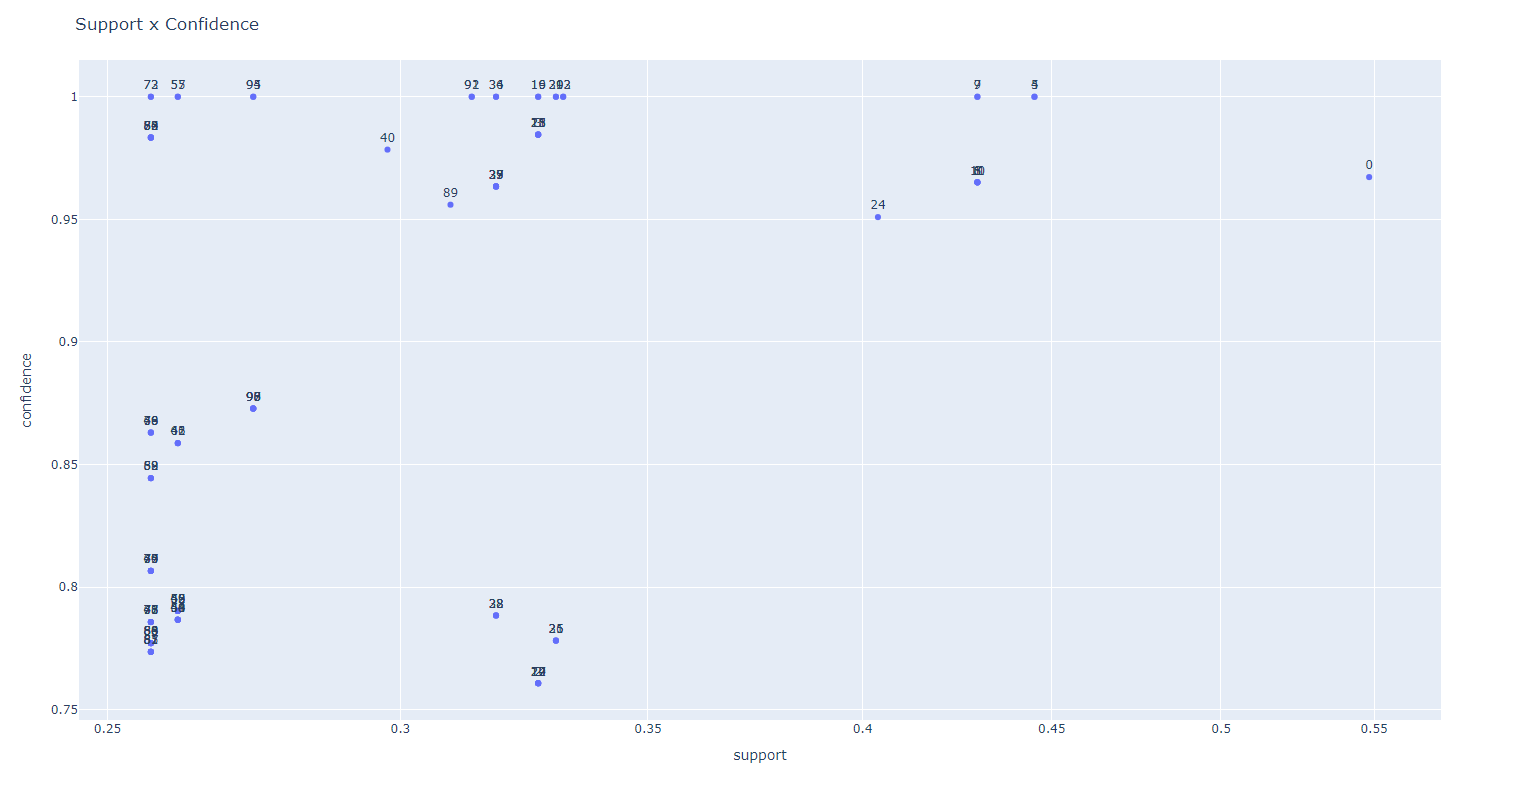

In [2]:
import pandas as pd
import plotly.express as px

df = pd.read_csv("association_rules_conf75.csv").drop(columns=["Unnamed: 0"])

fig = px.scatter(df, x="lift", y="conviction", text=df.index, log_x=True, size_max=60)

fig.update_traces(textposition='top center')

fig.update_layout(
    height=800,
    title_text='Lift x Conviction'
)

fig.show()

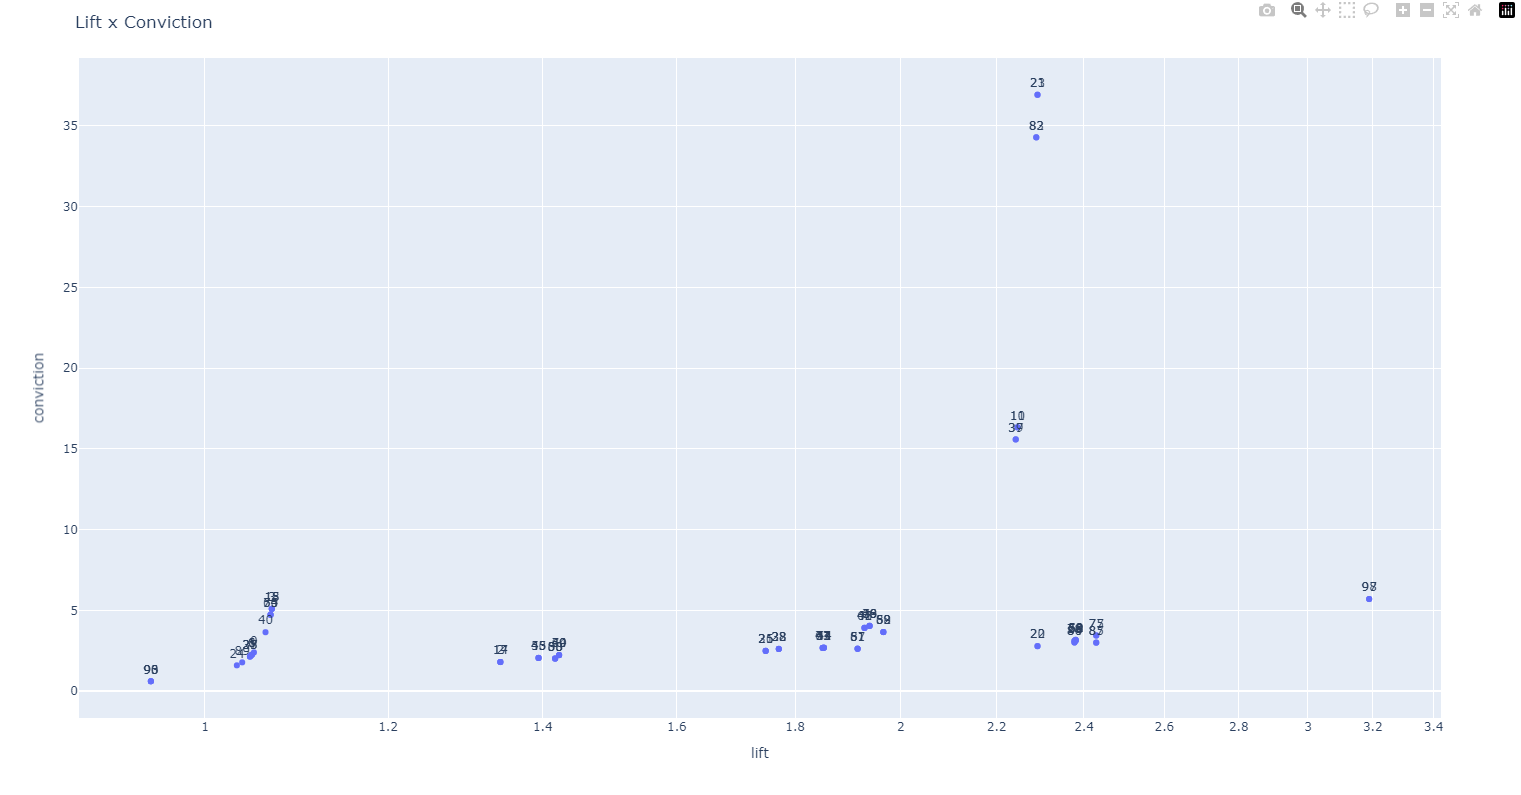

É possível plotar um gráfico que permite correlacionar métricas para buscar padrões de interesse. Nos gráficos os pontos se comportam de forma bem diferente. No primeiro, é possível achar regras fortes, consistentes e populares, graças ao `Suporte`; no segundo também é possível medir a força dessas regras, mas também é levado em conta o teor informativo do antecedente com o consequente, graças ao `Lift`. Para encontrar as que são mais interessantes deve-se ter a clareza com o que procura-se encontrar com essas informações. No caso, o objetivo é encontrar correlações interessantes para traçar um comportamento comum em motoristas infratores, portanto o suporte não pode ser muito baixo

Anteriormente, foi feita uma análise manual dos padrões encontrados, usando o discernimento humano e conhecimento da semântica das métricas.

Estabelecendo alguns limiares, com o auxílio dos gráficos é possível filtrar ainda mais e encontrar padrões interessantes. Isso facilita a análise de resultados, pois muitas vezes, podem ser retornados centenas de regras para analisar.

In [1]:
import pandas as pd

df = pd.read_csv("association_rules_conf75.csv").drop(columns=["Unnamed: 0"])
df = df.loc[(df["support"] > 0.4) & (df["confidence"] > 0.90) & (df["lift"] > 2.0)]

display(df)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
4,frozenset({'SENTIDO_Centro/Barro Preto'}),"frozenset({'ENDEREÇO_Av. do Contorno, oposto a...",0.445195,0.445195,0.445195,1.000000,2.246206,1.0,0.246996,inf,1.000000,1.000000,1.000000,1.00000
5,"frozenset({'ENDEREÇO_Av. do Contorno, oposto a...",frozenset({'SENTIDO_Centro/Barro Preto'}),0.445195,0.445195,0.445195,1.000000,2.246206,1.0,0.246996,inf,1.000000,1.000000,1.000000,1.00000
7,"frozenset({'SENTIDO_Centro/Barro Preto', 'VELC...","frozenset({'ENDEREÇO_Av. do Contorno, oposto a...",0.429657,0.445195,0.429657,1.000000,2.246206,1.0,0.238376,inf,0.972757,0.965099,1.000000,0.98255
9,"frozenset({'VELCOIDADE_velocidadeAlta', 'ENDER...",frozenset({'SENTIDO_Centro/Barro Preto'}),0.429657,0.445195,0.429657,1.000000,2.246206,1.0,0.238376,inf,0.972757,0.965099,1.000000,0.98255
10,frozenset({'SENTIDO_Centro/Barro Preto'}),"frozenset({'VELCOIDADE_velocidadeAlta', 'ENDER...",0.445195,0.429657,0.429657,0.965099,2.246206,1.0,0.238376,16.341753,1.000000,0.965099,0.938807,0.98255
11,"frozenset({'ENDEREÇO_Av. do Contorno, oposto a...","frozenset({'SENTIDO_Centro/Barro Preto', 'VELC...",0.445195,0.429657,0.429657,0.965099,2.246206,1.0,0.238376,16.341753,1.000000,0.965099,0.938807,0.98255
